## Distibuted Training With Hyperparameter tuning and Generic Model Flavors

In [1]:
import numpy as np
import tensorflow as tf
import mlflow
import time
import json
from sys import version_info
from mlflow.models import infer_signature
print("TF Version :", tf.__version__)

TF Version : 2.19.0


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ds_with_mlflow_flavor").master("spark://spark-master:7077") \
        .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/09 08:57:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
mlflow_uri = "http://mlflow-server:8888"
mlflow.set_tracking_uri(mlflow_uri)
time.sleep(5)
#mlflow.set_experiment(mlflow_uri)
mlflow.set_experiment("ds_with_mlflow_flavor")

<Experiment: artifact_location='mlflow-artifacts:/777633001559788292', creation_time=1746778587321, experiment_id='777633001559788292', last_update_time=1746778587321, lifecycle_stage='active', name='ds_with_mlflow_flavor', tags={}>

In [4]:
# load dataset
mnist = tf.keras.datasets.mnist

(x_train, y_train) , (x_test,y_test) = mnist.load_data()
x_train,x_test =  x_train/255.0 , x_test/255.0

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


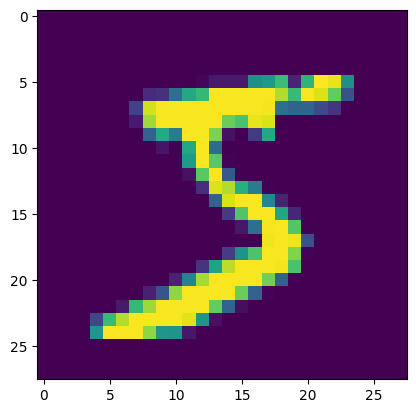

In [5]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [6]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt import SparkTrials, Trials

spark_trails = Trials()

In [7]:
from sys import version_info
conda_env_tf = {
    "channels": ["defaults"],
    "dependencies": [
        f"python={version_info.major}.{version_info.minor}.{version_info.micro}",
        "pip",
        {"pip": ["mlflow",
                 f"tensorflow=={tf.__version__}"]
        },
    ],
    "name": "tf_env"
}
conda_env_tf

{'channels': ['defaults'],
 'dependencies': ['python=3.12.10',
  'pip',
  {'pip': ['mlflow', 'tensorflow==2.19.0']}],
 'name': 'tf_env'}

In [8]:
import json
class custom_tf_model(mlflow.pyfunc.PythonModel):
    def __init__(self,params):
        self.params = params
        self.tf_model = None
        self.config = None

    def load_context(self, context = None, config_path = None):
        if context:
            config_path = context.artifacts["config_path"]
            
        else:
            pass
        self.config = json.load(open(config_path))

    
    def fit(self,x_train,y_train):

        tf_model = self.create_model(p_optimizer=self.config["optimizer"],
                                     l1_noNode=self.config["l1_noNode"],
                                     l1_activation = self.config["l1_activation"],
                                     l1_dropout = self.config["l1_dropout"])

        print(x_train.shape)
        tf_model.fit(x_train,y_train,epochs = self.params["epochs"])
        self.tf_model = tf_model


    def predict(self,context, model_input):
        
        return self.tf_model.predict(model_input)
    
    def evaluate(self,context,test_x,test_y):
        eval_loss, eval_acc = self.tf_model.evaluate(x_test,y_test,verbose=2)
        return eval_loss, eval_acc


    def create_model(self,p_optimizer = "Adam", l1_noNode= 32, l1_activation="relu",l1_dropout= 0.2):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(l1_noNode,activation=l1_activation),
            tf.keras.layers.Dropout(l1_dropout),
            tf.keras.layers.Dense(10)
        ])

        loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(optimizer = p_optimizer,loss= loss_func, metrics = ['accuracy'])

        return model
    





/usr/local/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [12]:
def train_with_hyperopt(params):
    with mlflow.start_run(nested=True) as run1 :
        p_epoch = params["epochs"]
        p_optimizer = params["optimizer"]
        l1_noNode = params["l1_noNode"]
        l1_activation = params["l1_activation"]
        l1_dropout  = params["l1_dropout"]


        mlflow.log_params(params)

        # create the configfile
        config_path = "data_tf.json"
        artifacts_tf = {"config_path" : config_path}   
        with open(config_path,"w") as f:
            json.dump(params,f)
        
        # create generic model
        params_ = {"epochs" : 5}
        config_path = "data_tf.json"
        custom_tf_model_obj = custom_tf_model(params_)
        custom_tf_model_obj.load_context(config_path=config_path)
        custom_tf_model_obj.fit(x_train=x_train,y_train=y_train)

        # Calculate LOSS and Acc
        eval_loss, eval_acc = custom_tf_model_obj.evaluate(context=None,
                                                           test_x=x_test,
                                                           test_y=y_test)

     
        mlflow.log_metric("eval_loss",eval_loss)
        mlflow.log_metric("eval_acc",eval_acc)


        # Prepare to generic model
        predictions_tf = custom_tf_model_obj.predict(context=None,model_input=x_test)
        model_signature = infer_signature(x_test,predictions_tf)
        mlflow.pyfunc.log_model(
            "custom_tf",
            python_model = custom_tf_model_obj,
            artifacts = artifacts_tf,
            conda_env = conda_env_tf,
            signature = model_signature,
            input_example = x_train[0:5]
        )


    return {"loss" : eval_loss, "status" : STATUS_OK, "model" : custom_tf_model_obj, "eval_acc":eval_acc}
        

In [13]:
epochs = [2,4,6,8]
optimizer = ["Adam","SGD","RMSprop"]
l1_noNode = [32,64,128]
l1_activation = ["relu","tanh","softmax"]
l1_dropout = [0.2,0.3,0.6]


search_params_space = {
    "epochs" : hp.choice("epochs",epochs),
    "optimizer" : hp.choice("optimizer",optimizer),
    "l1_noNode" : hp.choice("l1_noNode",l1_noNode),
    "l1_activation" : hp.choice("l1_activation",l1_activation),
    "l1_dropout" : hp.choice("l1_dropout",l1_dropout)
}

algo = tpe.suggest


In [14]:
algo

<function hyperopt.tpe.suggest(new_ids, domain, trials, seed, prior_weight=1.0, n_startup_jobs=20, n_EI_candidates=24, gamma=0.25, verbose=True)>

In [15]:
with mlflow.start_run() as run :
   args_min = fmin(
      fn=train_with_hyperopt,
      space=search_params_space,
      algo = algo,
      max_evals=3,
      trials=spark_trails
   )

2025/05/09 08:57:46 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



(60000, 28, 28)                                      
Epoch 1/5                                            

  0%|          | 0/3 [00:01<?, ?trial/s, best loss=?]

2025-05-09 08:57:47.545194: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 13:44 440ms/step - accuracy: 0.1250 - loss: 2.5639
  28/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2545 - loss: 2.1703     
  65/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3592 - loss: 1.9082
  99/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4211 - loss: 1.7461
 129/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4610 - loss: 1.6363
 167/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5001 - loss: 1.5267
 203/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5302 - loss: 1.4426
 240/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5554 - loss: 1.3716
 279/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5771 - loss: 1.3101
 317/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5952 - loss: 1.2586
 338/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6040 - loss: 1.2333
 358/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6118 - loss: 1.2108
 396/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6252 - lo

2025-05-09 08:58:04.052651: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 - 0s - 1ms/step - accuracy: 0.9684 - loss: 0.1060

  1/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
 52/313 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
156/313 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
259/313 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
  0%|          | 0/3 [00:17<?, ?trial/s, best loss=?]

2025-05-09 08:58:04.478509: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step

  0%|          | 0/3 [00:17<?, ?trial/s, best loss=?]

2025/05/09 08:58:04 INFO mlflow.pyfunc: Validating input example against model signature

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

🏃 View run valuable-flea-110 at: http://mlflow-server:8888/#/experiments/777633001559788292/runs/d58e85b058804ca98b0a2892b718cc1e

🧪 View experiment at: http://mlflow-server:8888/#/experiments/777633001559788292

 33%|███▎      | 1/3 [00:19<00:38, 19.32s/trial, best loss: 0.10597192496061325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001003 seconds

INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.105972



(60000, 28, 28)                                                                 
 33%|███▎      | 1/3 [00:19<00:38, 19.32s/trial, best loss: 0.10597192496061325]

/usr/local/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/5                                                                       

 33%|███▎      | 1/3 [00:19<00:38, 19.32s/trial, best loss: 0.10597192496061325]

2025-05-09 08:58:06.492773: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 5:23 173ms/step - accuracy: 0.1250 - loss: 2.3054
  54/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - accuracy: 0.1284 - loss: 2.2993  
 138/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.1235 - loss: 2.3009
 231/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.1227 - loss: 2.3010
 322/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.1236 - loss: 2.3007
 415/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - accuracy: 0.1252 - loss: 2.3002
 509/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.1266 - loss: 2.2997
 605/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.1277 - loss: 2.2992
 697/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.1290 - loss: 2.2986
 794/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.1306 - loss: 2.2981
 882/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.1323 - loss: 2.2975
 959/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.1341 - loss: 2.2970
1029/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - a

2025-05-09 08:58:13.225172: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 - 0s - 653us/step - accuracy: 0.5128 - loss: 1.3878                     

  1/313 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step              
166/313 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step    
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step   

 33%|███▎      | 1/3 [00:26<00:38, 19.32s/trial, best loss: 0.10597192496061325]

2025/05/09 08:58:13 INFO mlflow.pyfunc: Validating input example against model signature



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step         
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step         

🏃 View run fun-sheep-646 at: http://mlflow-server:8888/#/experiments/777633001559788292/runs/073a88c1600b4161b55ec8de1167f94c

🧪 View experiment at: http://mlflow-server:8888/#/experiments/777633001559788292

 67%|██████▋   | 2/3 [00:27<00:12, 12.73s/trial, best loss: 0.10597192496061325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001012 seconds

INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.105972



(60000, 28, 28)                                                                 
 67%|██████▋   | 2/3 [00:27<00:12, 12.73s/trial, best loss: 0.10597192496061325]

/usr/local/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/5                                                                       

   1/1875 ━━━━━━━━━━━━━━━━━━━━ 4:48 154ms/step - accuracy: 0.1875 - loss: 2.2805
  43/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1991 - loss: 2.2449    
 115/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - accuracy: 0.2825 - loss: 2.1121
 197/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - accuracy: 0.3509 - loss: 1.9865
 279/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.4004 - loss: 1.8820
 365/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.4395 - loss: 1.7896
 450/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.4691 - loss: 1.7131
 536/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.4936 - loss: 1.6468
 622/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.5142 - loss: 1.5891
 708/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.5319 - loss: 1.5382
 793/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.5473 - loss: 1.4933
 879/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step 

2025/05/09 08:58:22 INFO mlflow.pyfunc: Validating input example against model signature



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step         
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step         

🏃 View run salty-ant-498 at: http://mlflow-server:8888/#/experiments/777633001559788292/runs/f88eab8bb3b248948f34a1615537a93e

🧪 View experiment at: http://mlflow-server:8888/#/experiments/777633001559788292

100%|██████████| 3/3 [00:36<00:00, 12.01s/trial, best loss: 0.10597192496061325]
🏃 View run dapper-robin-201 at: http://mlflow-server:8888/#/experiments/777633001559788292/runs/8207ba269b334d89bbff70a26c442425
🧪 View experiment at: http://mlflow-server:8888/#/experiments/777633001559788292


In [ ]:
### Generic model flavours

In [16]:
args_min

{'epochs': 2,
 'l1_activation': 0,
 'l1_dropout': 2,
 'l1_noNode': 2,
 'optimizer': 0}

In [ ]:
import mlflow
logged_model = 'runs:/330340b36fe24a9081a9d910f5c6f766/custom_tf'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
# Predict on a Pandas DataFrame.
import pandas as pd
result = loaded_model.predict(x_test[:10])
result

In [17]:
spark.stop()